# Interactive loading of PHOENIX NewEra JWST synthetic stellar spectra h5 files
Model grids published in The NewEra model grid ([Hauschildt _et al_., 2025](https://ui.adsabs.harvard.edu/abs/2025arXiv250417597H))

Data and sample code published at [DOI: 10.25592/uhhfdm.16727](https://doi.org/10.25592/uhhfdm.17156).

This loosely derived from `example_read_HSR_H5.py`.

In [1]:
from pathlib import Path

#%matplotlib widget 
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.interpolate import interp1d

# Specific requirement for these files
import h5py
import f90nml

from libs.neweraspectra import make_newera_filename, download_newera_file

from deblib.constants import c

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


### Parse the SPECTRA h5 file

Download on demand the corresponding data file.

Files located at [https://www.fdr.uni-hamburg.de/record/16738/files/](https://www.fdr.uni-hamburg.de/record/16738/files/)

In [2]:
# Selection criteria
Teff = 5800
logg = 4.5
Z = 0.0

In [3]:
save_dir = Path("./libs/data/newera/")
filename = make_newera_filename(Teff, logg, Z)
download_newera_file(filename, save_dir)

File libs/data/newera/lte05800-4.50-0.0.PHOENIX-NewEra-ACES-COND-2023.HSR.h5 exists.


Parse the file for HSR and LSR spectral data. The `phoenix_nml` contains metadata in the form of a `f90nml`.

In [4]:
with h5py.File(save_dir / filename, "r") as fh5:
    # read the HSR spectrum: 
    wl = fh5['/PHOENIX_SPECTRUM/wl'][()] / 1e4          # wavelength (vacuum) from Angstroem to um
    flux = 10.**fh5['/PHOENIX_SPECTRUM/flux'][()]       # flux, stored as log10 values
    bb_flux = 10.**fh5['/PHOENIX_SPECTRUM/bb'][()]      # BB flux, stored as log10 values

    # read the LSR spectrum: 
    wl_lsr = fh5['/PHOENIX_SPECTRUM_LSR/wl'][()] / 1e4  # wavelength (vacuum) from Angstroem to um
    fl_lsr = 10.**fh5['/PHOENIX_SPECTRUM_LSR/fl'][()]   # flux, stored as log10 values

    # Read the namelist
    target_nml = f90nml.reads(str(fh5['/PHOENIX_NAMELIST/phoenix_nml'][()].tobytes())[2:-1])

    # this is the stdout file (as a string):
    stdout_str = (str(fh5['/PHOENIX_STDOUT/phx_stdout'][()].tobytes()))[2:-1]

    # this is the restart file (as a string):
    restart_str = (str(fh5['/PHOENIX_RESTART/phx_restart'][()].tobytes()))[2:-1]

In [5]:
# Print out some contents from the namelist
for key in ["teff", "logg", "m_sun", "mixlng", "zscale", "alpha_scale"]:
    print(f"{key}\t= {target_nml['phoenix'][key]}")

print(f"HSR spectrum covers {wl.min()} to {wl.max()} um in {len(wl):,d} bins")
print(f"LSR spectrum covers {wl_lsr.min()} to {wl_lsr.max()} um in {len(wl_lsr):,d} bins")

teff	= 5800.0
logg	= 4.5
m_sun	= 1.01042564631
mixlng	= 1.58851928542
zscale	= 0.0
alpha_scale	= 0.0
HSR spectrum covers 0.09 to 930.0 um in 13,149,991 bins
LSR spectrum covers 0.001 to 950.0 um in 473,418 bins


In [6]:
# now extract some values:
teff = target_nml['phoenix']['teff']
r0 = target_nml['phoenix']['r0']
v0 = target_nml['phoenix']['v0']
logg = target_nml['phoenix']['logg']
zscale = target_nml['phoenix']['zscale']
alpha_scale = target_nml['phoenix']['alpha_scale']
m_sun  = target_nml['phoenix']['m_sun']
wltau  = target_nml['phoenix']['wltau']
ngrrad  = target_nml['phoenix']['ngrrad']
ieos  = target_nml['phoenix']['ieos']
mixlng  = target_nml['phoenix']['mixlng']

### Plot the spectrum

In [7]:
# Prepare interpolators as a simple way to downsample the spectral data
mask = (wl_lsr >= 0.25) & (wl_lsr <= 22)
lambdas = wl_lsr[mask]
fl_interp = interp1d(lambdas, fl_lsr[mask], "cubic")

bb_mask = (wl >= 0.25) & (wl <= 22)
bb_interp = interp1d(wl[bb_mask], bb_flux[bb_mask], "linear")

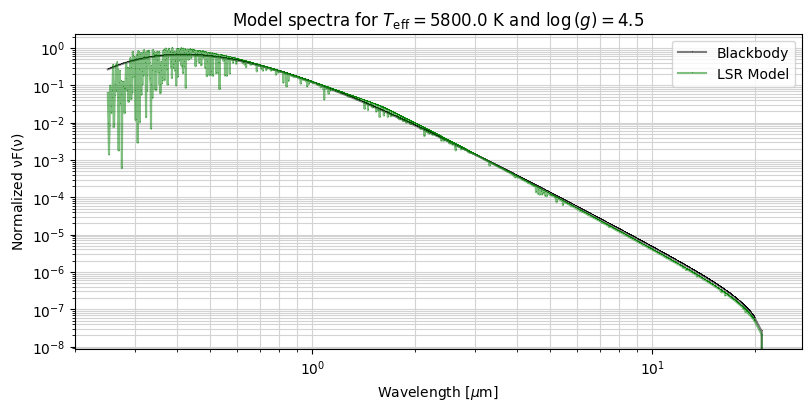

In [8]:
plot_lambdas = lambdas[::100]
plot_freq = c * 1e6 / plot_lambdas

# Prep the spectrum
vfv = fl_interp(plot_lambdas) * plot_freq
norm_scale = vfv.max() - vfv.min()
norm_vfv = (vfv - vfv.min()) / norm_scale

# Prep equivalent BB spectrum
plot_bb_vfv = bb_interp(plot_lambdas) * plot_freq
norm_bb_vfv = (plot_bb_vfv - plot_bb_vfv.min()) / norm_scale

title = f"Model spectra for $T_{{\\rm eff}}={teff}$ K and $\\log{{(g)}}={logg}$"
fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
ax.loglog(plot_lambdas, norm_bb_vfv, ",-k", alpha=0.5, label="Blackbody")
ax.loglog(plot_lambdas, norm_vfv, ",-g", alpha=0.5, label="LSR Model")
ax.set(title=title, xlabel=r"Wavelength [$\mu$m]", ylabel=r"Normalized ${\rm \nu F(\nu)}$")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)